# Workshop 5. Clasificación no supervisada (K-Means) con imágenes multibanda 🗺️

**Estudiantes:**
>
>María Fernanda López 🦄
>
>Megan García Antivar 🦄
                
**Curso:** Geoprocesamiento, Universidad Nacional de Colombia  

**Reference:** *Data Science – Unsupervised Classification of Satellite Images with K-Means Algorithm* 

## 🗺️ Descripción general

Este cuaderno demuestra una clasificación de cobertura terrestre no supervisada utilizando el algoritmo K-Means. El flujo de trabajo sigue el tutorial en línea [Disponible aquí](https://ml-gis-service.com/index.php/2020/10/14/data-science-unsupervised-classification-of-satellite-images-with-k-means-algorithm/), adaptado a un único GeoTIFF multibanda recortado.

**Etapas clave**

1. Importar las bibliotecas necesarias y crear un subconjunto recortado.
2. Mostrar una vista previa RGB en color natural.
3. Reestructurar el subconjunto en una matriz de características bidimensional.
4. Construir y entrenar `ClusteredStack`, una clase que encapsula el flujo de trabajo de K-Means.
5. Inspeccionar los mapas clasificados, la inercia (método del codo) y las puntuaciones de silueta.
6. Guardar el mapa óptimo como un nuevo ráster.

## A. Importar librerías

In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [24]:
import os
import shutil

# Standard and scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterstats import point_query
import rasterio.windows as rwin
import geopandas as gpd
import rsgislib
import rsgislib.imageutils
import rsgislib.vectorutils
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import rsgislib.tools.mapping
import rsgislib.imageutils
import rsgislib.classification
import rsgislib.classification.classsklearn

# Machine-learning tools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#tqdm
from tqdm.notebook import tqdm

# Image-enhancement for visual interpretation
from skimage.exposure import equalize_adapthist

## 1. Cargar los conjuntos de datos y generar un subconjunto de trabajo

La imagen satelital cargada se visualiza utilizando una composición en color natural, correspondiente a las bandas 4 (rojo), 3 (verde) y 2 (azul) de Sentinel-2. Para mejorar la visualización:

- Se aplica un estiramiento de contraste por percentiles (2–98%) a cada banda.
- Se utiliza una corrección gamma (γ = 0.8) para suavizar el brillo general.
- El resultado se muestra como una imagen RGB apilada.

Esta técnica mejora el contraste ignorando los valores atípicos, lo que facilita distinguir las características sin distorsionar la apariencia general.

Cada banda (Rojo, Verde, Azul) se estira de forma **independiente** utilizando su propio rango del 1–99 %, asegurando que se conserve el balance de color y el contraste.

La **corrección gamma** ajusta el brillo de los tonos medios sin alterar drásticamente los píxeles más oscuros o más brillantes. Se aplica *después* del estiramiento y ayuda a afinar la apariencia de la imagen para una mejor interpretación visual.

La fórmula de corrección gamma se define como:

$$
\text{output\_pixel} = (\text{input\_pixel})^\gamma
$$

Donde:

- $\text{input\_pixel}$ es el valor de píxel normalizado (entre 0 y 1),  
- $\gamma$ es el coeficiente gamma,  
- $\text{output\_pixel}$ es el valor de brillo ajustado.  

### 1.1. Definición de la ruta al archivo raster

Se define la ruta a la imagen satelital Sentinel-2 utilizando un alias local (`data/`) creado previamente con un enlace simbólico. Esta práctica permite simplificar rutas extensas y mantener el código más limpio y reutilizable.

In [3]:
raster_path = 'data/sentinel2_2018_epsg3116.tif'

with rio.open(raster_path) as src:
    img = src.read()  # (bands, rows, cols)

### 1.2. Implementación del procesamiento visual en color natural

A continuación, se implementa el procesamiento de la imagen Sentinel-2 previamente cargada para visualizarla en color natural:

- Se seleccionan las bandas 4 (rojo), 3 (verde) y 2 (azul), ubicadas en las posiciones [2, 1, 0] del array `img`.
- Cada banda se normaliza individualmente aplicando estiramiento por percentiles 2–98%.
- Las bandas resultantes se apilan en un array RGB y se les aplica corrección gamma (`γ = 0.8`) para mejorar el brillo medio.
- Finalmente, la imagen se visualiza usando Matplotlib.

Este procedimiento permite una visualización equilibrada y estéticamente clara del área de estudio.

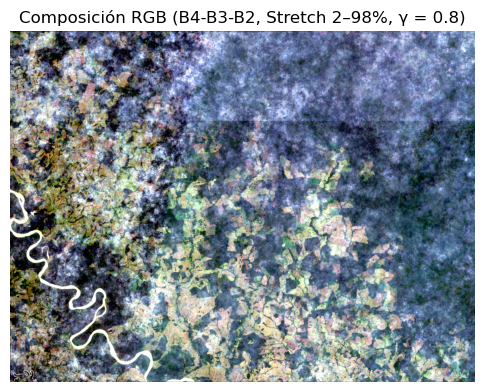

In [4]:
# img: array previamente cargado con shape (bands, rows, cols)
# Sentinel-2 RGB = bandas 4 (R), 3 (G), 2 (B) = índices 2, 1, 0
bands_rgb = [2, 1, 0]  # B4, B3, B2
gamma = 0.8  # Control de brillo: <1 = más brillante

channels = []
for b in bands_rgb:
    band = img[b].astype(float)
    band = np.nan_to_num(band)

    # Estiramiento por percentiles
    lo, hi = np.percentile(band, (2, 98))
    band = np.clip((band - lo) / (hi - lo), 0, 1)

    channels.append(band)

# Apilar y aplicar corrección gamma
rgb = np.dstack(channels) ** gamma

# Visualizar
plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title("Composición RGB (B4-B3-B2, Stretch 2–98%, γ = 0.8)")
plt.axis("off")
plt.show()

👆🏼 ¿y qué hace este código?

| Función / Método                         | Descripción                                                                                   |
|------------------------------------------|-----------------------------------------------------------------------------------------------|
| `img[b].astype(float)`                   | Convierte los valores de la banda a tipo flotante para permitir cálculos posteriores.        |
| `np.nan_to_num(band)`                    | Reemplaza valores `NaN` por cero (u otro valor por defecto) para evitar errores en cálculos. |
| `np.percentile(band, (2, 98))`           | Calcula los percentiles 2 y 98 para aplicar un estiramiento de contraste a la banda.         |
| `np.clip((band - lo) / (hi - lo), 0, 1)` | Normaliza la banda a valores entre 0 y 1, eliminando valores extremos.                       |
| `np.dstack(channels)`                    | Apila las tres bandas (R, G, B) en una sola imagen tridimensional (alto, ancho, 3).          |
| `** gamma`                               | Aplica corrección gamma para ajustar el brillo de la imagen.                                 |
| `plt.imshow(rgb)`                        | Muestra la imagen RGB en pantalla usando Matplotlib.                                         |
| `plt.axis("off")`                        | Oculta los ejes del gráfico para una visualización más limpia.                              |

### 1.3. Exploración preliminar del raster Sentinel-2

Antes de realizar cualquier análisis, es fundamental inspeccionar el raster para entender su estructura interna. A continuación se exploran:

- El número total de bandas contenidas en el archivo.
- Las descripciones disponibles para cada banda.
- El sistema de referencia espacial (CRS).
- La resolución espacial del raster (tamaño del píxel).
- Las dimensiones de la imagen (ancho y alto en píxeles).

Esta información permitirá seleccionar adecuadamente las bandas a utilizar en las visualizaciones y análisis posteriores.

In [5]:
raster_path = 'data/sentinel2_2018_epsg3116.tif'

with rio.open(raster_path) as src:
    print(f"El raster tiene {src.count} bandas.\n")

    for i in range(1, src.count + 1):
        desc = src.descriptions[i - 1]
        print(f"Banda {i}: {desc}")

with rio.open(raster_path) as src:
    print("Resolución (tamaño de pixel):", src.res)
    print("Sistema de referencia:", src.crs)
    print("Dimensiones (ancho x alto):", src.width, "x", src.height)
    print("Número de bandas:", src.count)

El raster tiene 10 bandas.

Banda 1: B2
Banda 2: B3
Banda 3: B4
Banda 4: B5
Banda 5: B6
Banda 6: B7
Banda 7: B8
Banda 8: B8A
Banda 9: B11
Banda 10: B12
Resolución (tamaño de pixel): (9.975197822782095, 9.975197822782095)
Sistema de referencia: EPSG:3116
Dimensiones (ancho x alto): 4360 x 3288
Número de bandas: 10


#### Tabla descriptiva de bandas Sentinel-2

Según los metadatos extraídos, la imagen contiene 10 bandas, cuyas descripciones corresponden al estándar de Sentinel-2. A continuación se presenta una tabla resumen:

| Nº Banda (raster) | Nombre | Longitud de onda aprox. | Descripción                  | Aplicaciones principales             |
|-------------------|--------|--------------------------|------------------------------|--------------------------------------|
| Banda 1           | B2     | ~490 nm                  | Azul                         | Agua, atmósfera                      |
| Banda 2           | B3     | ~560 nm                  | Verde                        | Vegetación                           |
| Banda 3           | B4     | ~665 nm                  | Rojo                         | Vegetación, suelos                   |
| Banda 4           | B5     | ~705 nm                  | Red Edge 1                   | Vegetación                           |
| Banda 5           | B6     | ~740 nm                  | Red Edge 2                   | Vegetación/clorofila                 |
| Banda 6           | B7     | ~783 nm                  | Red Edge 3                   | Vegetación                           |
| Banda 7           | B8     | ~842 nm                  | NIR (infrarrojo cercano)     | NDVI, biomasa vegetal                |
| Banda 8           | B8A    | ~865 nm                  | Red Edge 4 / NIR estrecho    | Análisis avanzado de vegetación      |
| Banda 9           | B11    | ~1610 nm                 | SWIR 1                       | Humedad del suelo, vegetación seca   |
| Banda 10          | B12    | ~2190 nm                 | SWIR 2                       | Detección de incendios, suelos secos |

> ⚠️ **Nota**: en este archivo raster, la banda 1 corresponde a la banda B2 de Sentinel-2 (azul). La banda B1 (aerosoles) no está incluida, probablemente por haber sido excluida en el proceso de pretratamiento o la fuente original de los datos.

📌 **Fuente**: [European Space Agency – Sentinel-2 MSI Overview](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2)

### 1.4. Gráfico de dispersión entre bandas

Con el fin de explorar visualmente la relación entre bandas espectrales, se genera un gráfico de dispersión para todos los píxeles válidos de la imagen Sentinel-2. En este caso se comparan:

- **Banda 2 (Azul)**: útil para estudiar cuerpos de agua y penetración atmosférica.
- **Banda 4 (Rojo)**: sensible a la vegetación y su interacción con la luz visible.

Esta visualización permite identificar tendencias, agrupamientos o relaciones no lineales entre las bandas, lo cual es útil como paso previo a métodos como la clasificación no supervisada.

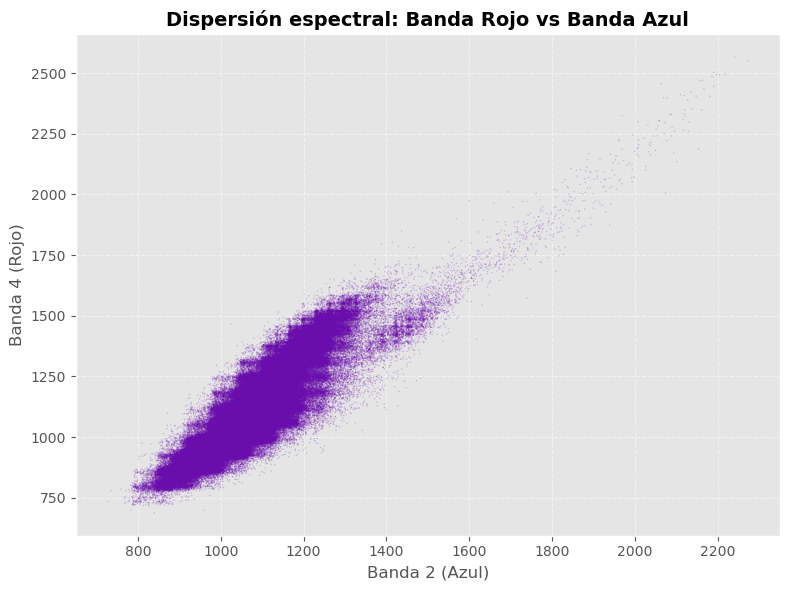

In [6]:
plt.style.use("ggplot") 

raster_path = 'data/sentinel2_2018_epsg3116.tif'

with rio.open(raster_path) as src:
    blue = src.read(2).astype(float)
    red = src.read(4).astype(float)

x = blue.flatten()
y = red.flatten()
mask = (x > 0) & (y > 0)
x = x[mask]
y = y[mask]

if len(x) > 500000:
    idx = np.random.choice(len(x), 500000, replace=False)
    x = x[idx]
    y = y[idx]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, s=1, alpha=0.25, color="#6a0dad", edgecolors='none')

ax.set_xlabel("Banda 2 (Azul)", fontsize=12)
ax.set_ylabel("Banda 4 (Rojo)", fontsize=12)
ax.set_title("Dispersión espectral: Banda Rojo vs Banda Azul", fontsize=14, weight='bold')

ax.grid(True, linestyle='--', alpha=0.5)
ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

#### 1.4.1. Interpretación del gráfico de dispersión: Banda Azul vs Banda Roja

El gráfico muestra la relación espectral entre la Banda 2 (Azul) y la Banda 4 (Rojo) de Sentinel-2, donde cada punto representa un píxel de la imagen: 

- **Correlación positiva**: Se observa una tendencia creciente: a mayor reflectancia en azul, mayor reflectancia en rojo. Esto es típico en coberturas como suelos desnudos, áreas urbanas claras o vegetación dispersa.

- **Alta densidad en valores intermedios (1000–1500)**: La mayor concentración de píxeles se da en valores medios de reflectancia, lo que sugiere una predominancia de coberturas con comportamiento espectral intermedio, como áreas mixtas.

- **Puntos con alta reflectancia azul (>1800)**: Indican superficies muy reflectantes en el espectro azul, como cuerpos de agua claros, techos blancos o materiales reflectivos.

- **Baja presencia de reflectancia alta en rojo**: La falta de puntos con valores altos en la banda roja sugiere escasa presencia de superficies que reflejan mucho en esa región del espectro.


## 2. Clasificación no supervisada con la clases `ClusteredStack`  

La clase `ClusteredStack` encapsula todo el flujo de trabajo para realizar una clasificación no supervisada de una imagen multibanda utilizando el algoritmo K-Means. Esta clase permite:

- Leer y transformar la imagen en el formato requerido por `scikit-learn`.
- Entrenar modelos de K-Means para diferentes valores de `k`.
- Evaluar los modelos usando las métricas de inercia y silueta.
- Visualizar los resultados de la clasificación para cada `k` en formato de mapa.

> A continuación, se describen los principales métodos de esta clase.

In [7]:
class ClusteredStack:
    
    def __init__(self, raster_path):
        self.raster_path = raster_path
        self.model_input = None
        self.height = self.width = self.depth = 0
        self.k_range = []
        self.models = []
        self.predicted_rasters = []
        self.inertia_scores = []
        self.silhouette_scores = []

    def set_raster_stack(self):
        """Lectura del raster y preparación de datos para K-Means."""
        with rio.open(self.raster_path) as src:
            stack = src.read()
            stack = np.nan_to_num(stack)
        self.depth, self.height, self.width = stack.shape
        self.model_input = stack.reshape(self.depth, -1).T

    def build_models(self, k_values):
        """Entrena modelos KMeans para distintos valores de k."""
        self.k_range = list(k_values)
        self.models, self.predicted_rasters = [], []
        self.inertia_scores, self.silhouette_scores = [], []

        for k in self.k_range:
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = km.fit_predict(self.model_input)

            self.models.append(km)
            self.inertia_scores.append(km.inertia_)
            self.silhouette_scores.append(
                silhouette_score(self.model_input, labels, sample_size=1000)
            )
            self.predicted_rasters.append(labels.reshape(self.height, self.width))

    def show_clustered(self, cmap="Accent", cols=3):
        """
        Muestra las imágenes clasificadas en una grilla (máx. 3 por fila).
        """
        total = len(self.k_range)
        rows = (total + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
        axes = axes.flatten()

        for idx, (k, img_cls) in enumerate(zip(self.k_range, self.predicted_rasters)):
            ax = axes[idx]
            im = ax.imshow(img_cls, cmap=cmap)
            ax.set_title(f"{k} clusters")
            ax.axis("off")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # Ocultar subgráficos vacíos
        for ax in axes[total:]:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    def show_inertia(self):
        """Muestra el método del codo para selección de k."""
        plt.figure(figsize=(6, 4))
        plt.plot(self.k_range, self.inertia_scores, "o-", linewidth=2, color="darkblue")
        plt.xlabel("Número de clusters (k)")
        plt.ylabel("Inercia")
        plt.title("Método de Inercia")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

    def show_silhouette(self):
        """Muestra los coeficientes de silueta por k."""
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.silhouette_scores, "o-")
        plt.xlabel("Número de clusters (k)")
        plt.ylabel("Coeficiente de silueta")
        plt.title("Puntajes de silueta")
        plt.show()

### 2.1. Métodos – Clase `ClusteredStack`

La siguiente tabla resume los métodos definidos dentro de la clase `ClusteredStack`, diseñada para realizar una clasificación no supervisada mediante el algoritmo K-Means sobre imágenes ráster multibanda. 

| Método                        | Propósito principal                                                                 | Operaciones clave                                                                                   |
|------------------------------|--------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| `__init__(self, raster_path)`| Inicializar la clase con la ruta al raster y atributos vacíos                       | Define atributos para almacenar datos de entrada, resultados y métricas                             |
| `set_raster_stack(self)`     | Leer el raster y prepararlo para el algoritmo KMeans                                | Lee el raster, reemplaza NaN por 0, reestructura a (n_pixeles, n_bandas)                            |
| `build_models(self, k_values)`| Entrenar modelos KMeans para una lista de valores `k`                               | Ajusta KMeans, guarda etiquetas, calcula inercia y silueta, reestructura las etiquetas a raster     |
| `show_clustered(self)`       | Visualizar los resultados de clasificación por cada `k`                             | Muestra las imágenes clasificadas por `k` usando un mapa de colores categórico                      |
| `show_inertia(self)`         | Graficar la inercia de cada modelo (método del codo)                                | Dibuja curva de inercia para identificar el valor óptimo de `k`                                     |
| `show_silhouette(self)`      | Graficar los puntajes de silueta de cada modelo                                     | Mide la calidad de separación entre clústeres, útil para comparar modelos con distinto número de `k`|

### 2.2. Flujo de trabajo clasificación no supervisada
El siguiente bloque implementa un flujo completo de clasificación no supervisada usando K-Means sobre un ráster multibanda.

#### 2.2.1. Carga y transformación del ráster

Se realiza una sola lectura del archivo ráster multibanda y se reestructura para ser compatible con scikit-learn:

- Abre el ráster usando `rasterio` en un bloque `with`, asegurando el cierre seguro del archivo.
- Lee todas las bandas como una pila 3D con forma `(bandas, filas, columnas)`.
- Reemplaza cualquier valor faltante (`NaN`) por 0 con `np.nan_to_num()`.
- Almacena las dimensiones del ráster como atributos de clase (`depth`, `height`, `width`).
- Reestructura la pila en una matriz 2D de forma `(n_pixeles, n_bandas)`, formato compatible con scikit-learn.

> Este método reemplaza al *Listing 5: ClusteredBands – set bands stack method* del tutorial original.

In [8]:
# 1. Instanciar el objeto con la ruta al ráster
clustered_models = ClusteredStack('data/sentinel2_2018_epsg3116.tif')

# 2. Leer y transformar el raster
clustered_models.set_raster_stack()

#### 2.2.2. Definición del rango de clústeres

Se define un rango de valores `k` (número de clústeres) a evaluar. En este caso, se prueban valores de `k` de 3 a 10.


In [9]:
ranges = np.arange(3, 11, 1)

#### 2.2.3. Entrenamiento de modelos K-Means

Para cada valor de `k`, se entrena un modelo K-Means, se predicen las etiquetas por píxel, y se calculan métricas clave:

- Inercia (para el método del codo)
- Puntaje de silueta (para evaluar separación entre clústeres)
- Imagen clasificada reconstruida (etiquetas con forma raster)


In [10]:
clustered_models.build_models(ranges)

#### 2.2.4. Visualización de resultados

Se muestran los resultados de clasificación y las métricas de evaluación:

- Mapas de clústeres para cada valor de k
- Curva de inercia (Elbow method)
- Puntajes de silueta

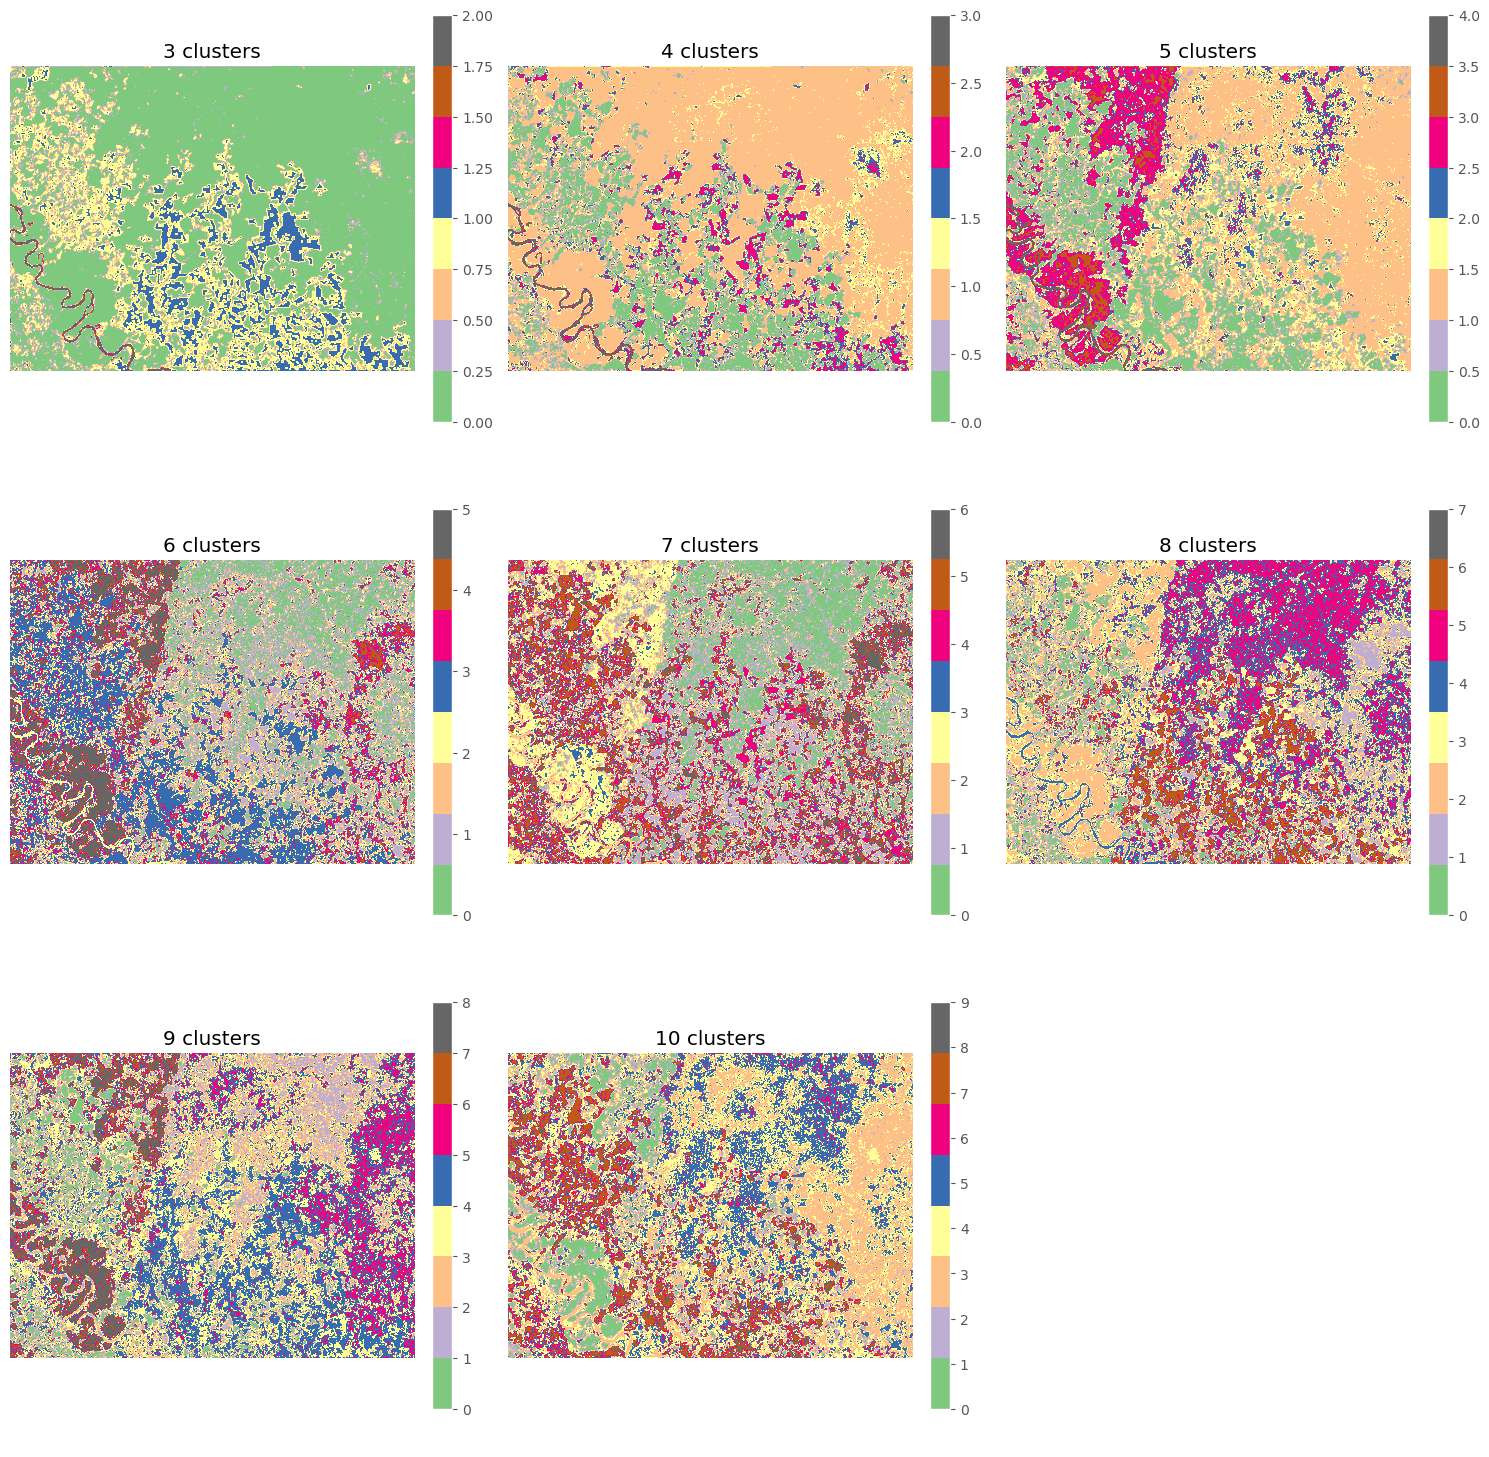

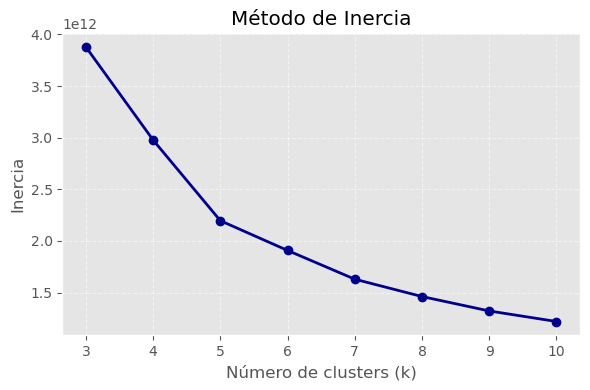

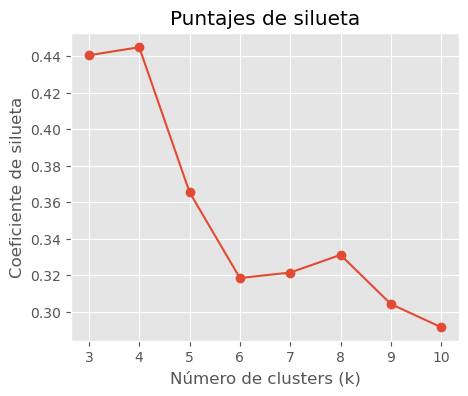

In [11]:
clustered_models.show_clustered()
clustered_models.show_inertia()

# Alias opcional para mantener compatibilidad con el tutorial original
ClusteredStack.show_silhouette_scores = ClusteredStack.show_silhouette
clustered_models.show_silhouette_scores()

## 3. Elegir el mejor resultado de la clasificación no supervisada

Al evaluar los valores de inercia (`método del codo`), observamos una fuerte disminución hasta `k` = 4, luego el cambio marginal se reduce. Esto sugiere que agregar más clústeres a partir de este punto aporta poco a la compactación interna de los grupos.

Adicionalmente, el `coeficiente de silueta` alcanza un valor relativamente alto en `k` = 4, lo que indica una buena separación entre clústeres (vegetación, cuerpos de agua, suelo desnudo, etc.) sin superposición significativa.

> En la segmentación espacial para `k` = 4, se identifican claramente zonas diferenciadas:

> * Un clúster se asocia con vegetación densa (alta reflectancia en NIR),
> * Otro con zonas agrícolas o pastos (transiciones de rojo y verde),
> * Uno más corresponde a superficies sin vegetación o áreas degradadas,
> * Y un último agrupa cuerpos de agua o sombras densas.

La distribución espacial de los clústeres refleja patrones de uso del suelo evidentes en la imagen RGB, y puede ser usada como insumo para análisis multiclase o preclasificación supervisada.

Valores únicos del raster: [0 1 2 3]


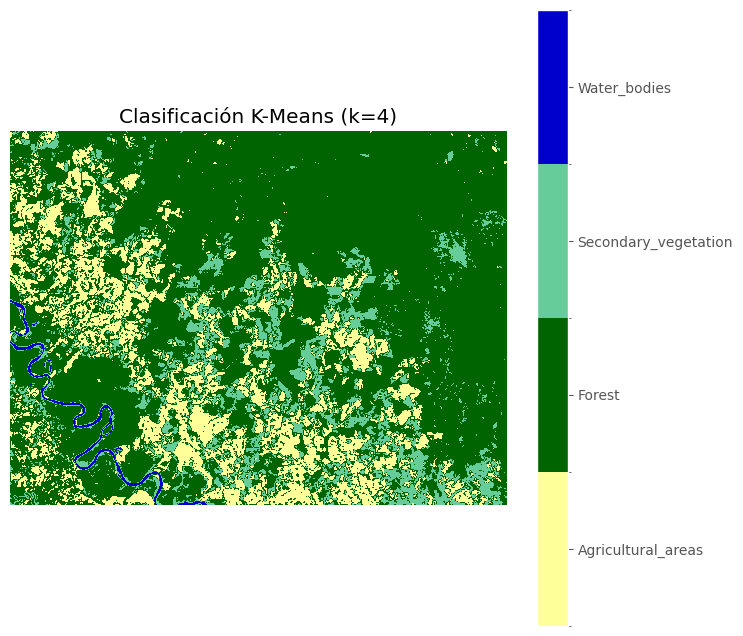

In [12]:
# Raster de KMeans con k=4
labels = clustered_models.predicted_rasters[clustered_models.k_range.index(4)]
valores = np.unique(labels)

# Revisa los valores presentes
print("Valores únicos del raster:", valores)

# Asignar colores y etiquetas en el orden exacto de los valores
colores = ["#ffff99", "#006400", "#66cc99", "#0000cc"]  # amarillo, verde oscuro, verde claro, azul
etiquetas = ["Agricultural_areas", "Forest", "Secondary_vegetation", "Water_bodies"]

# Crear colormap y normalización
cmap = ListedColormap(colores)
bounds = np.arange(len(valores) + 1) - 0.5
norm = BoundaryNorm(bounds, cmap.N)

# Graficar
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(labels, cmap=cmap, norm=norm)
ax.set_title("Clasificación K-Means (k=4)")
ax.axis("off")

# Barra de color con etiquetas
cbar = plt.colorbar(im, ax=ax, ticks=valores)
cbar.ax.set_yticklabels(etiquetas)
plt.show()

## 4. Random Forest vs. K-Means

En esta sección se compara el resultado de la clasificación no supervisada mediante K-means con el resultado de una clasificación supervisada utilizando el algoritmo Random Forest (RF).  
El objetivo de esta comparación es evaluar en qué medida los patrones descubiertos automáticamente por el algoritmo no supervisado se alinean con las clases temáticas obtenidas a partir de entrenamiento supervisado.

K-means, al ser un algoritmo de aprendizaje no supervisado, identifica agrupaciones basadas exclusivamente en la similitud espectral de los píxeles, sin conocimiento previo de las clases reales.  En contraste, Random Forest se entrena con muestras etiquetadas y aprovecha dicha información para clasificar el resto del raster según características espectrales y patrones aprendidos.

La comparación permitirá observar:

- El **grado de coincidencia espacial** entre ambas clasificaciones.
- Las **diferencias en la definición de bordes** o zonas de transición.
- El **nivel de detalle o generalización** en las categorías resultantes.
- La **efectividad de K-means como insumo para preclasificación** en contextos donde no se dispone de entrenamiento supervisado.

Esta evaluación es útil tanto para validar el comportamiento del algoritmo K-means como para explorar su potencial en tareas de segmentación preliminar, insumo para clasificación multiclase o análisis exploratorios en escenarios con limitados datos etiquetados.

Image Data Size: 4360 x 3288


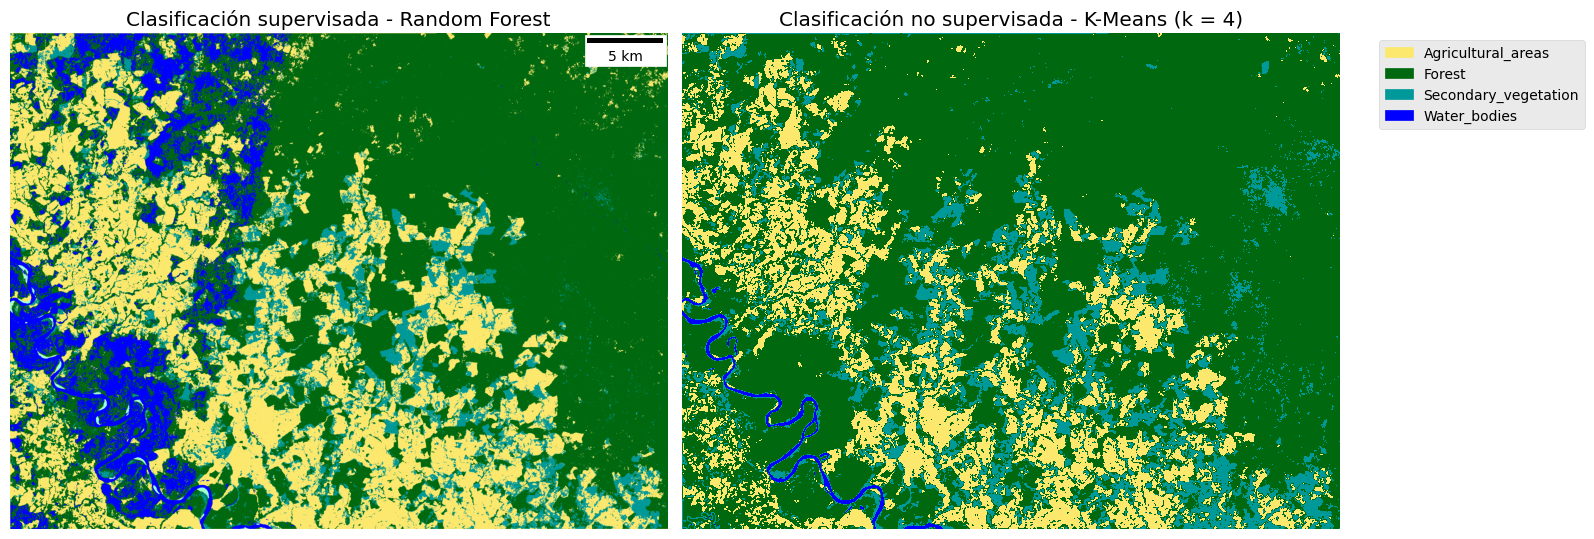

In [13]:
# Diccionario de clases y colores RGB
class_labels = {
    "Agricultural_areas": (252, 232, 109),
    "Forest": (0, 105, 16),
    "Secondary_vegetation": (0, 153, 153),
    "Water_bodies": (0, 0, 255)
}

# Conversión a formato matplotlib (0–1)
def rgb_to_mpl(rgb):
    return tuple(v / 255 for v in rgb)

# Extraer colores y etiquetas corregidas
colores = [rgb_to_mpl(rgb) for rgb in class_labels.values()]
etiquetas = list(class_labels.keys())

# Raster de KMeans (k=4)
labels_kmeans = clustered_models.predicted_rasters[clustered_models.k_range.index(4)]
valores_kmeans = np.unique(labels_kmeans)

# Adaptar colores y etiquetas solo a clases presentes
colores_kmeans = colores[:len(valores_kmeans)]
etiquetas_kmeans = etiquetas[:len(valores_kmeans)]

# Crear colormap y normalización
cmap_kmeans = ListedColormap(colores_kmeans)
bounds = np.arange(len(valores_kmeans)+1) - 0.5
norm = BoundaryNorm(bounds, cmap_kmeans.N)

# Crear figura comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Clasificación supervisada - Random Forest
rsgislib.tools.mapping.create_thematic_raster_map(
    ax=ax1,
    input_img="data/clasificacion_rf_2018.kea"
)
ax1.set_title("Clasificación supervisada - Random Forest")
ax1.axis("off")

# Clasificación no supervisada - K-means (k=4)
im = ax2.imshow(labels_kmeans, cmap=cmap_kmeans, norm=norm)
ax2.set_title("Clasificación no supervisada - K-Means (k = 4)")
ax2.axis("off")

# Leyenda común
legend_patches = [
    mpatches.Patch(color=colores_kmeans[i], label=etiquetas_kmeans[i])
    for i in range(len(valores_kmeans))
]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

La imagen anterior presenta una comparación lado a lado entre los resultados de:

- **Clasificación supervisada mediante Random Forest** (izquierda), entrenada con muestras etiquetadas que representan coberturas reales del territorio, y  
- **Clasificación no supervisada mediante K-means con k = 4** (derecha), basada únicamente en patrones espectrales sin conocimiento previo de clases.

Ambas clasificaciones utilizan una paleta de colores consistente para facilitar la interpretación comparativa: verde para áreas boscosas, amarillo para zonas agrícolas, cian para vegetación secundaria y azul para cuerpos de agua.

A pesar de las diferencias metodológicas, se observan patrones de coincidencia espacial importantes entre ambas clasificaciones, especialmente en la delimitación de áreas boscosas y cuerpos de agua. Sin embargo, el modelo no supervisado tiende a subestimar ciertas transiciones o zonas intermedias que la clasificación supervisada logra captar con mayor precisión gracias al entrenamiento.

### 4.1. Agregar la clasificación no supervisada (K-Means) como covariable espectral

Con el fin de utilizar la clasificación no supervisada como insumo en procesos posteriores (por ejemplo, como variable explicativa o máscara de segmentación), se extrae el resultado de K-means con `k = 4` y se añade como una nueva banda a la imagen satelital original.

Este procedimiento permite:

- Conservar la coherencia espacial entre la imagen y la clasificación.
- Tratar el resultado del clustering como una *banda adicional* junto al resto de las bandas espectrales.
- Exportar un nuevo raster multibanda listo para análisis adicionales (por ejemplo, entrenamiento de modelos supervisados incluyendo la agrupación previa).

La banda añadida contiene valores discretos que representan el grupo al que cada píxel fue asignado según su firma espectral.

>Se selecciona el valor de `k` que se desea utilizar (en este caso, `k = 4`) y se extrae el resultado correspondiente desde el objeto `clustered_models`.  
El resultado es una matriz 2D donde cada píxel contiene el número de clúster al que fue asignado por el algoritmo K-means. Esta matriz servirá como la nueva banda a añadir a la imagen satelital.


In [14]:
k = 4
cluster_img = clustered_models.predicted_rasters[clustered_models.k_range.index(k)]

#### 4.1.2. Leer la imagen satelital base y extraer metadatos

Se carga la imagen satelital original (`raster_path`) para recuperar sus metadatos y dimensiones espaciales. Esto es necesario para apilar correctamente la nueva banda del clúster.

In [15]:
with rio.open(raster_path) as src:
    profile = src.profile.copy()
    img_data = src.read()  # shape: (bands, rows, cols)

#### 4.1.3. Verificar compatibilidad espacial

Se verifica que la imagen de clústeres tenga las mismas dimensiones espaciales (filas, columnas) que la imagen base.

In [16]:
print("Satellital shape:", img_data.shape[1:], "| Clusters shape:", cluster_img.shape)

Satellital shape: (3288, 4360) | Clusters shape: (3288, 4360)


#### 4.1.4. Apilar bandas

Se expande la dimensión del clúster para que tenga 3 ejes `(1, filas, columnas)` y luego se concatena al arreglo original, generando una imagen multibanda con una banda adicional.

In [17]:
# Expandimos la dimensión para que sea 3D (1, rows, cols)
cluster_band = np.expand_dims(cluster_img, axis=0)

# Concatenamos la banda nueva (cluster) al final
stacked_img = np.concatenate((img_data, cluster_band), axis=0)  # shape: (bands+1, rows, cols)

#### 4.1.5. Seleccionar tipo de dato automáticamente

Se calcula el valor máximo en la banda de clústeres para determinar si puede ser almacenada como `uint8` (0–255) o si requiere `uint16` (mayores valores). Esto previene errores de escritura o truncamiento.

In [18]:
max_val = cluster_img.max()
dtype_out = "uint8" if max_val <= 255 else "uint16"
print(f"Máximo valor en clúster: {max_val} → Tipo de dato: {dtype_out}")

profile.update({
    "count": stacked_img.shape[0],
    "dtype": dtype_out
})

Máximo valor en clúster: 3 → Tipo de dato: uint8


#### 4.1.6. Exportar imagen multibanda con K-Means

Una vez que se ha generado la imagen multibanda con la banda adicional de K-Means (agrupación no supervisada), se procede a exportarla como archivo `.tif`.

Este archivo será utilizado como entrada en procesos posteriores, como la extracción de muestras o el entrenamiento de modelos supervisados que incorporen esta clasificación previa como covariable.

Se escribe en disco usando `rasterio`, respetando el perfil actualizado con el número de bandas y el tipo de dato adecuado (`uint8` o `uint16`).

In [52]:
import os
import rasterio as rio
import numpy as np

# Crear carpeta temporal de salida
os.makedirs("tmp", exist_ok=True)

# Ruta de salida
out_path_temp_kmeans = "tmp/sat_kmeans_stack.tif"

# Confirmar dimensiones y tipo
print("Exportando imagen con forma:", stacked_img.shape)

# Escribir imagen multibanda al disco
with rio.open(out_path_temp_kmeans, "w", **profile) as dst:
    for i in range(stacked_img.shape[0]):
        # Reemplazar valores inválidos antes de escribir
        cleaned = np.nan_to_num(stacked_img[i, :, :], nan=0, posinf=0, neginf=0)
        dst.write(cleaned.astype(profile["dtype"]), i + 1)

print("✅ Imagen multibanda con K-Means exportada:", out_path_temp_kmeans)

Exportando imagen con forma: (11, 3288, 4360)
✅ Imagen multibanda con K-Means exportada: tmp/sat_kmeans_stack.tif


In [61]:
ruta = "tmp/sat_kmeans_stack.tif"

with rasterio.open(ruta) as src:
    print("Ruta:", ruta)
    print("Dimensiones (ancho x alto):", src.width, "x", src.height)
    print("Número de bandas:", src.count)
    print("CRS:", src.crs)
    print("Tipo de dato:", src.dtypes)

Ruta: tmp/sat_kmeans_stack.tif
Dimensiones (ancho x alto): 4360 x 3288
Número de bandas: 11
CRS: EPSG:3116
Tipo de dato: ('uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8')


## 5. Clasificación Random Forest con K-Means como covariable

En esta sección se realiza una clasificación supervisada utilizando el algoritmo de Random Forest, incluyendo como **covariable adicional** la salida de una clasificación no supervisada K-Means (con k=4).

El objetivo es evaluar si la segmentación previa mejora la capacidad predictiva del clasificador al incorporar información contextual o estructural que las bandas espectrales originales podrían no capturar por sí solas.

### 5.1. Exportar imagen multibanda con K-Means como última banda

En esta etapa se construye un nuevo archivo raster .tif que contiene las bandas espectrales originales de Sentinel-2 y una banda adicional generada a partir de la clasificación no supervisada K-Means (con k = 4).
Esta exportación es clave para que el clasificador supervisado (por ejemplo, Random Forest) pueda acceder a la agrupación como una covariable espacial, ya que RSGISLib trabaja con rutas a archivos físicos en disco.

In [68]:
import os
import numpy as np
import rasterio as rio

# --- (1) Crear carpeta de salida temporal ---
os.makedirs("tmp", exist_ok=True)
out_path_temp_kmeans = "tmp/sat_kmeans_stack.tif"

# --- (2) Confirmar dimensiones y tipo ---
print("Exportando imagen con forma:", stacked_img.shape)

# --- (3) Actualizar metadatos ---
profile.update({
    "count": stacked_img.shape[0],
    "dtype": "uint8",  # o "uint16" si es necesario
    "height": stacked_img.shape[1],
    "width": stacked_img.shape[2]
})

# --- (4) Escribir imagen multibanda ---
with rio.open(out_path_temp_kmeans, "w", **profile) as dst:
    for i in range(stacked_img.shape[0]):
        banda_limpia = np.nan_to_num(stacked_img[i], nan=0, posinf=0, neginf=0)
        dst.write(banda_limpia.astype(profile["dtype"]), i + 1)

print("✅ Imagen multibanda con K-Means exportada:", out_path_temp_kmeans)

Exportando imagen con forma: (11, 3288, 4360)
✅ Imagen multibanda con K-Means exportada: tmp/sat_kmeans_stack.tif


In [70]:
import subprocess

tif_path = "tmp/sat_kmeans_stack.tif"
kea_path = "tmp/sat_kmeans_stack.kea"

# Convertir .tif a .kea usando gdal_translate
subprocess.run([
    "gdal_translate",
    "-of", "KEA",
    tif_path,
    kea_path
])

print("✅ Imagen convertida de .tif a .kea:", kea_path)

Input file size is 4360, 3288
0...10...20...30...40...50...60...70...80...90...100 - done.
✅ Imagen convertida de .tif a .kea: tmp/sat_kmeans_stack.kea


### 5.2. Preparar ImageBandInfo con la imagen multibanda exportada *.tif

Una vez que se ha exportado la imagen multibanda que incluye la banda de K-Means, es necesario construir el objeto ImageBandInfo, el cual especifica a RSGISLib:

- Qué archivo raster utilizar como fuente de datos espectrales.
- Cuántas bandas tiene y en qué orden se encuentran.
- Un nombre arbitrario para identificar ese grupo de bandas.

Este objeto es esencial para extraer las muestras de entrenamiento por clase mediante get_class_training_data.

In [71]:
from rsgislib.classification import ImageBandInfo

# Ruta de imagen exportada
out_path_temp_kmeans = "tmp/sat_kmeans_stack.tif"

# Crear objeto ImageBandInfo para RSGISLib
img_band_info_kmeans = [
    ImageBandInfo(
        name="sen2_with_kmeans",
        file_name=out_path_temp_kmeans,
        bands=[i + 1 for i in range(stacked_img.shape[0])]
    )
]

# Verificación
print("🔍 Bandas especificadas:", img_band_info_kmeans[0].bands)
print("📂 Archivo asociado:", img_band_info_kmeans[0].file_name)

🔍 Bandas especificadas: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
📂 Archivo asociado: tmp/sat_kmeans_stack.tif


### 5.3. Creación de máscara

In [4]:
# Abrir la imagen base solo para obtener dimensiones y metadata
input_img = '/notebooks/Geoprocesamiento/Workshop/data/Workshop_3/sat_kmeans_stack.tif'

with rio.open(input_img) as src:
    shape = (src.height, src.width)
    profile = src.profile

# Crear máscara binaria con todo a 1 (válido)
mask = np.ones(shape, dtype=np.uint8)

# Actualizar metadata para que sea archivo de una sola banda
profile.update({
    "count": 1,
    "dtype": 'uint8',
    "nodata": 0  # define explícitamente qué es inválido
})

# Guardar como GeoTIFF
with rio.open("/notebooks/Geoprocesamiento/Workshop/data/Workshop_3/sentinel2_2018_vmask.tif", "w", **profile) as dst:
    dst.write(mask, 1)

In [5]:
input_img = "data/Workshop_3/sat_kmeans_stack.tif"
in_msk_img = "data/Workshop_3/sentinel2_2018_vmask_3116.tif"
vec_train_file = "data/Workshop_3/Training_data_epsg3116.gpkg"

In [6]:
lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(vec_train_file)
print(lyr_names )

['Training_data_epsg3116', 'Water_bodies', 'Agricultural_areas', 'sparsely_or_no_vegetated_areas', 'Forest', 'Secondary_vegetation']


### 5.4. Extraer muestras con la banda de K-Means incluida

En este paso se extraen las firmas espectrales por clase, utilizando como fuente la imagen satelital multibanda con la banda de K-Means incluida (exportada previamente en formato .tif). Esta banda adicional representa la agrupación no supervisada y se trata como una covariable espectral más en el proceso de entrenamiento.

Se utilizan las geometrías vectoriales de entrenamiento (almacenadas en un GeoPackage con múltiples capas) y se definen mediante objetos ClassVecSamplesInfoObj, uno por cada clase. Cada objeto incluye:

- El nombre de la clase y su ID.
- El nombre de la capa dentro del archivo vectorial.
- La ruta al archivo de salida .h5 donde se almacenarán los valores espectrales extraídos.

Estos archivos HDF5 pueden luego combinarse para entrenar el modelo Random Forest.

In [7]:
img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    )
)
print(img_band_info)

[('sen2', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'data/Workshop_3/sat_kmeans_stack.tif')]


In [10]:
class_vec_sample_info = list()

# Define the file name of the samples HDF5 file, which will be created
agricultural_areas_h5 = "agricultural_areas_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="Agricultural_areas",
        vec_file=vec_train_file,
        vec_lyr="Agricultural_areas",
        file_h5=agricultural_areas_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
forest_h5 = "forest_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="Forest",
        vec_file=vec_train_file,
        vec_lyr="Forest",
        file_h5=forest_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
secondary_vegetation_h5 = "secondary_vegetation_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="Secondary_vegetation",
        vec_file=vec_train_file,
        vec_lyr="Secondary_vegetation",
        file_h5=secondary_vegetation_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
sparsely_no_veg_h5 = "sparsely_no_veg_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="sparsely or no vegetated areas",
        vec_file=vec_train_file,
        vec_lyr="sparsely_or_no_vegetated_areas",
        file_h5=sparsely_no_veg_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
water_bodies_h5 = "water_bodies_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="Water_bodies",
        vec_file=vec_train_file,
        vec_lyr="water_bodies",
        file_h5=water_bodies_h5,
    )
)

## See what is inside  class_vec_sample_info
print(class_vec_sample_info)

[<rsgislib.classification.ClassVecSamplesInfoObj object at 0x724dcd6505d0>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x724dcd650590>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x724dcd6506d0>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x724dcd650790>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x724dcd650910>]


In [11]:
obj = class_vec_sample_info[0]
vars(obj)        # returns a dictionary of attributes
# or
obj.__dict__

{'id': 1,
 'class_name': 'Agricultural_areas',
 'vec_file': 'data/Workshop_3/Training_data_epsg3116.gpkg',
 'vec_lyr': 'Agricultural_areas',
 'file_h5': 'agricultural_areas_smpls.h5'}

In [12]:
tmp_dir = "./tmp"

if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

In [13]:
cls_smpls_info = rsgislib.classification.get_class_training_data(
    img_band_info, class_vec_sample_info, tmp_dir, ref_img=in_msk_img
)

Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Creating output image using input image


Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Creating output image using input imageGet Image Min and Max.


Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




In [31]:
cls_smpls_info["Agricultural_areas"].red = 252
cls_smpls_info["Agricultural_areas"].green = 232
cls_smpls_info["Agricultural_areas"].blue = 109

cls_smpls_info["Forest"].red = 0
cls_smpls_info["Forest"].green = 105
cls_smpls_info["Forest"].blue = 16

cls_smpls_info["Secondary_vegetation"].red = 0
cls_smpls_info["Secondary_vegetation"].green = 153
cls_smpls_info["Secondary_vegetation"].blue = 153

cls_smpls_info["sparsely or no vegetated areas"].red = 156
cls_smpls_info["sparsely or no vegetated areas"].green = 255
cls_smpls_info["sparsely or no vegetated areas"].blue = 215

cls_smpls_info["Water_bodies"].red = 0
cls_smpls_info["Water_bodies"].green = 0
cls_smpls_info["Water_bodies"].blue = 255

cls_smpls_info

{'Agricultural_areas': 1: agricultural_areas_smpls.h5, (252, 232, 109),
 'Forest': 2: forest_smpls.h5, (0, 105, 16),
 'Secondary_vegetation': 3: secondary_vegetation_smpls.h5, (0, 153, 153),
 'sparsely or no vegetated areas': 4: sparsely_no_veg_smpls.h5, (156, 255, 215),
 'Water_bodies': 5: water_bodies_smpls.h5, (0, 0, 255)}

### 5.4.1. Validar muestras extraídas

Una vez extraídas las muestras espectrales de cada clase a partir de la imagen multibanda con la banda de K-Means incluida, es importante validar que:

- Los archivos .h5 fueron efectivamente generados en el directorio temporal tmp_kmeans/.
- Cada archivo contiene datos (no está vacío).
- Se generaron tantas muestras como se esperaba por clase.

A continuación se realiza una verificación sencilla:
- Se listan los archivos .h5 generados.
- Se abre cada archivo con h5py y se imprime su forma, es decir, cuántas muestras tiene y cuántas bandas por muestra.

In [32]:
for cls_name in cls_smpls_info:
    smpls_h5_file = cls_smpls_info[cls_name].file_h5
    n_smpls = rsgislib.classification.get_num_samples(smpls_h5_file)
    print(f"{cls_name}: {n_smpls}")

Agricultural_areas: 10061
Forest: 80391
Secondary_vegetation: 21150
sparsely or no vegetated areas: 1368
Water_bodies: 4321


In [33]:
# Define the output directory and create if it does not exist:
smpls_dir = "./cls_smpls"

if not os.path.exists(smpls_dir):
    os.mkdir(smpls_dir)


cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(
    cls_smpls_info, smpls_dir
)

print("\n keys",cls_smpls_fnl_info.keys())

# print the values of artificail_surfaces
print("\n keys",cls_smpls_fnl_info["sparsely or no vegetated areas"])

0=1: (Train:./cls_smpls/agricultural_areas_smpls_train.h5, Test:./cls_smpls/agricultural_areas_smpls_test.h5, Valid:./cls_smpls/agricultural_areas_smpls_valid.h5), (252, 232, 109)
1=2: (Train:./cls_smpls/forest_smpls_train.h5, Test:./cls_smpls/forest_smpls_test.h5, Valid:./cls_smpls/forest_smpls_valid.h5), (0, 105, 16)
2=3: (Train:./cls_smpls/secondary_vegetation_smpls_train.h5, Test:./cls_smpls/secondary_vegetation_smpls_test.h5, Valid:./cls_smpls/secondary_vegetation_smpls_valid.h5), (0, 153, 153)
3=4: (Train:./cls_smpls/sparsely_no_veg_smpls_train.h5, Test:./cls_smpls/sparsely_no_veg_smpls_test.h5, Valid:./cls_smpls/sparsely_no_veg_smpls_valid.h5), (156, 255, 215)
4=5: (Train:./cls_smpls/water_bodies_smpls_train.h5, Test:./cls_smpls/water_bodies_smpls_test.h5, Valid:./cls_smpls/water_bodies_smpls_valid.h5), (0, 0, 255)

 keys dict_keys(['Agricultural_areas', 'Forest', 'Secondary_vegetation', 'sparsely or no vegetated areas', 'Water_bodies'])

 keys 3=4: (Train:./cls_smpls/sparsely_n

In [34]:
# Run the create_train_valid_test_sets helper function to
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info, cls_smpls_fnl_info, 100, 100, 1000
)

In [35]:
print("Muestras finales por clase (entrenamiento / validación / prueba):\n")

for clase, info in cls_smpls_fnl_info.items():
    n_train = rsgislib.classification.get_num_samples(info.train_file_h5)
    n_valid = rsgislib.classification.get_num_samples(info.valid_file_h5)
    n_test = rsgislib.classification.get_num_samples(info.test_file_h5)

    print(f"🔸 {clase}")
    print(f"   Entrenamiento : {n_train}")
    print(f"   Validación    : {n_valid}")
    print(f"   Prueba        : {n_test}\n")

Muestras finales por clase (entrenamiento / validación / prueba):

🔸 Agricultural_areas
   Entrenamiento : 1005
   Validación    : 109
   Prueba        : 101

🔸 Forest
   Entrenamiento : 1041
   Validación    : 161
   Prueba        : 161

🔸 Secondary_vegetation
   Entrenamiento : 1005
   Validación    : 106
   Prueba        : 106

🔸 sparsely or no vegetated areas
   Entrenamiento : 1001
   Validación    : 101
   Prueba        : 101

🔸 Water_bodies
   Entrenamiento : 1002
   Validación    : 102
   Prueba        : 104



In [36]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 20, 50, 100, 150, 200],
        "max_depth": [4, 8, 10, 12, 14, 16],
    },
)
print(grid_search )
sk_classifier = (
    rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
        cls_smpls_fnl_info, grid_search
    )
)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 8, 10, 12, 14, 16],
                         'n_estimators': [10, 20, 50, 100, 150, 200]})
Training data size: 579 x 11
Best score was 0.8686806596701648 and has parameters {'max_depth': 8, 'n_estimators': 50}.


In [37]:
rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpls_fnl_info, sk_classifier
)

Training data size: 5054 x 11
Testing data size: 573 x 11
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 96.38%
Classifier Test Score = 91.27%


(0.9637910565888406, 0.912739965095986)

## 5.5. Aplicar modelo entrenado y generar clasificación

En este paso se utiliza el modelo Random Forest entrenado previamente (`modelo_rf_kmeans.pkl`) para clasificar toda la imagen multibanda, la cual incluye las bandas espectrales originales y la banda adicional de K-Means.

El resultado será una imagen ráster clasificada, donde cada píxel es asignado a una de las clases definidas en el conjunto de entrenamiento.

| Paso | Descripción |
|------|-------------|
| **Input** | - Imagen `sat_kmeans_stack.tif` con 11 bandas. <br> - Modelo entrenado `modelo_rf_kmeans.pkl`. |
| **Proceso** | Aplicar `classifyWithSKLearnModel()` para ejecutar clasificación por píxel con RSGISLib. |
| **Output** | Raster de clasificación supervisada con covariable K-Means. |

In [38]:
from osgeo import gdal
from rsgislib.classification import ImageBandInfo
import rsgislib.classification.classsklearn

# Definir rutas
input_img = "data/Workshop_3/sat_kmeans_stack.tif"
in_msk_img = "data/Workshop_3/sentinel2_2018_vmask_3116.tif"
out_cls_img = "clasificacion_rf_k_2018.kea"
out_scr_img = "clasificacion_rf_k_score_2018.kea"

# Obtener número de bandas
ds = gdal.Open(input_img)
n_bands = ds.RasterCount

# Crear objeto ImageBandInfo
img_band_info = [ImageBandInfo(name="sen2", file_name=input_img, bands=[i+1 for i in range(n_bands)])]

# Aplicar clasificador
rsgislib.classification.classsklearn.apply_sklearn_classifier(
    cls_smpls_fnl_info,  # cls_info
    sk_classifier,       # cls_obj
    in_msk_img,          # in_msk_img
    1,                   # img_msk_val
    img_band_info,       # img_file_info
    out_cls_img,         # out_class_img
    "KEA",               # gdalformat
    True,                # class_clr_names
    out_scr_img          # out__score_img
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Calculating Image Pyramids.





Apply Colour to class 'Agricultural_areas'
Apply Colour to class 'Forest'
Apply Colour to class 'Secondary_vegetation'
Apply Colour to class 'sparsely or no vegetated areas'
Apply Colour to class 'Water_bodies'


Image Data Size: 4360 x 3288


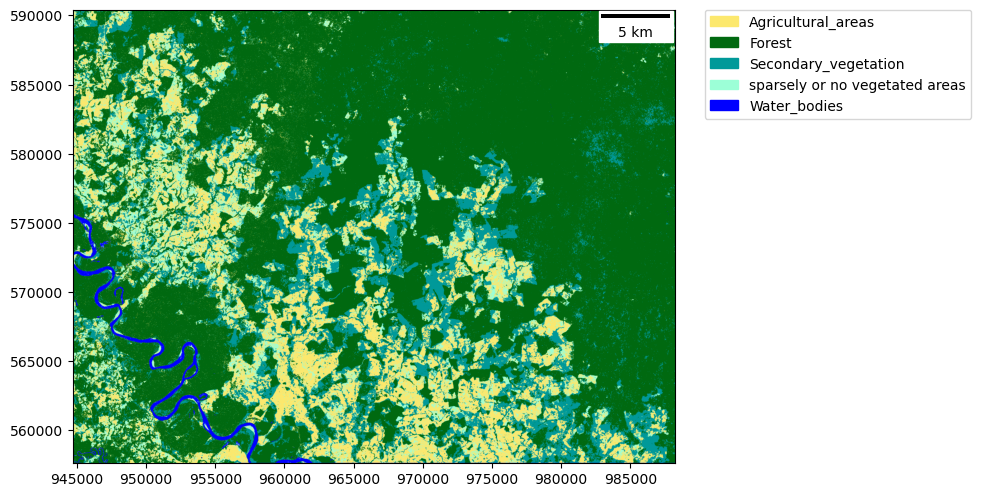

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rsgislib.tools.mapping

# Diccionario de clases y colores RGB (ejemplo)
class_labels = {
    "Agricultural_areas": (252, 232, 109),
    "Forest": (0, 105, 16),
    "Secondary_vegetation": (0, 153, 153),
    "sparsely or no vegetated areas": (156, 255, 215),
    "Water_bodies": (0, 0, 255)
}

# Convertir los colores RGB (0–255) a formato 0–1
def rgb_to_mpl(rgb):
    return tuple([v/255 for v in rgb])

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

# Mapa clasificado
rsgislib.tools.mapping.create_thematic_raster_map(
    ax=ax,
    input_img="clasificacion_rf_k_2018.kea"
)

# Crear leyenda personalizada
legend_patches = [
    mpatches.Patch(color=rgb_to_mpl(rgb), label=label)
    for label, rgb in class_labels.items()
]

# Añadir leyenda fuera del mapa
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

## 6. Comparación de las dos clasificaciones

Image Data Size: 4360 x 3288
Image Data Size: 4360 x 3288


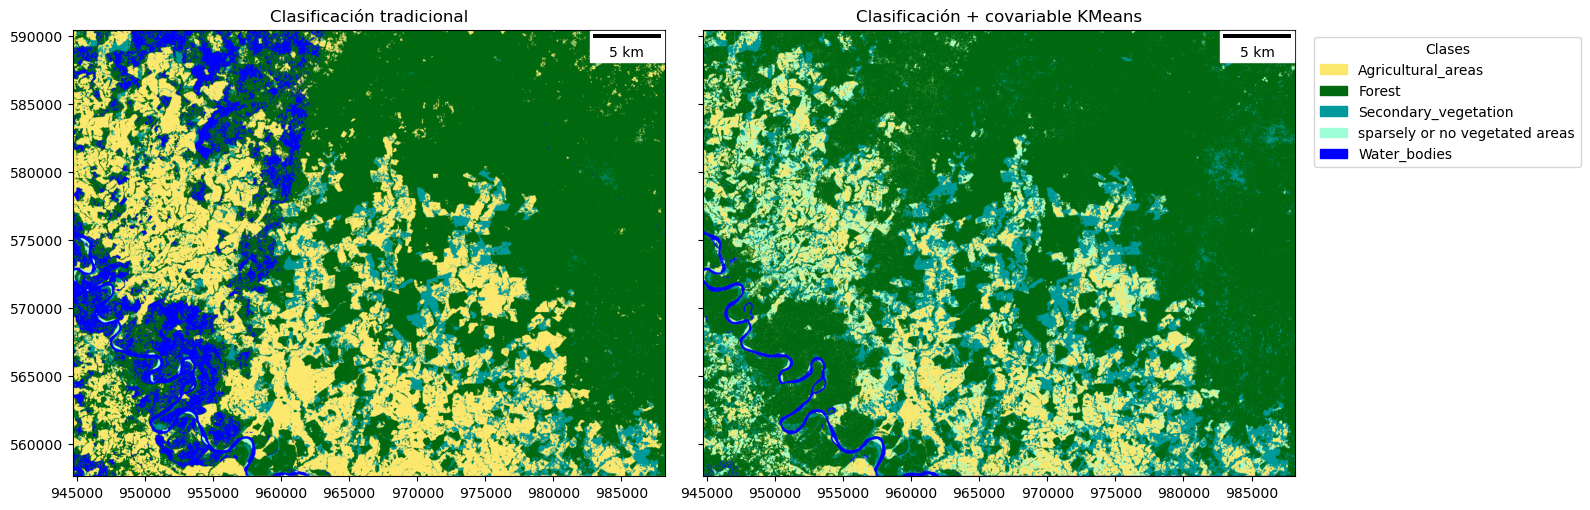

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rsgislib
from rsgislib import tools

# === Diccionario de clases y colores RGB (0–255)
class_labels = {
    "Agricultural_areas": (252, 232, 109),
    "Forest": (0, 105, 16),
    "Secondary_vegetation": (0, 153, 153),
    "sparsely or no vegetated areas": (156, 255, 215),
    "Water_bodies": (0, 0, 255)
}

# Convertir RGB 255 → 0–1 (para matplotlib)
def rgb_to_mpl(rgb):
    return tuple([v/255 for v in rgb])

# Ruta de las dos imágenes a comparar
img_clasica = "clasificacion_rf_2018.kea"
img_con_kmeans = "clasificacion_rf_k_2018.kea"

# Bounding box de la zona de análisis
sub_img_bbox = [944712.7306693317, 988204.5931766616, 557628.0093751058, 590426.4598164133]

# === Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Mapa clasificado tradicional
tools.mapping.create_thematic_raster_map(
    ax=ax1,
    input_img=img_clasica,
    bbox=sub_img_bbox
)
ax1.set_title("Clasificación tradicional")

# Mapa clasificado con covariable KMeans
tools.mapping.create_thematic_raster_map(
    ax=ax2,
    input_img=img_con_kmeans,
    bbox=sub_img_bbox
)
ax2.set_title("Clasificación + covariable KMeans")

# Crear parches de la leyenda (una sola para ambos mapas)
legend_patches = [
    mpatches.Patch(color=rgb_to_mpl(rgb), label=label)
    for label, rgb in class_labels.items()
]

# Añadir leyenda en el centro derecho
ax2.legend(
    handles=legend_patches,
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    title="Clases"
)

plt.tight_layout()
plt.show()

### 6.1 Evaluación de las mismas métricas

#### 6.1.1 Métricas clasificación supervisada

Primero se vuelven a cargar las métricas obtenidas con el modelo de clasificación supervisada.

In [42]:
## Ruta al archivo vectorial con puntos de validación
vec_file = "data/Workshop_3/Testing_points_epsg3116.gpkg"

# Nombre de la capa que contiene los puntos
vec_lyr = "amazontesting"

In [28]:
# Directorio para puntos de evaluación (por si se exportan)
out_pts_dir = "acc_pts"
os.makedirs(out_pts_dir, exist_ok=True)

# Directorio para resultados de métricas
out_stats_dir = "acc_stats"
os.makedirs(out_stats_dir, exist_ok=True)

print("Directorios creados o verificados correctamente.")

Directorios creados o verificados correctamente.


In [21]:
# Leer la capa
points_gdf = gpd.read_file(vec_file, layer=vec_lyr)

rename_map = {
    1: "Agricultural_areas",
    2: "Forest",
    5: "Water_bodies",
    6: "Secondary_vegetation",
    8: "sparsely or no vegetated areas"
}

# Reemplazar los valores en la columna "Reference"
points_gdf["Reference"] = points_gdf["Reference"].replace(rename_map)
# Sobrescribir la misma capa en el mismo archivo
points_gdf.to_file(vec_file, layer=vec_lyr, driver="GPKG")

In [24]:
# Leer la capa
points_gdf = gpd.read_file(vec_file, layer=vec_lyr)

rename_map = {
    1: "Agricultural_areas",
    2: "Forest",
    5: "Water_bodies",
    3: "Secondary_vegetation",
    4: "sparsely or no vegetated areas"
}

# Extraer valores del raster clasificado para cada punto
points_gdf["Classified"] = point_query(points_gdf, "clasificacion_rf_2018.kea", interpolate='nearest')

# Reemplazar los valores en la columna "Reference"
points_gdf["Classified"] = points_gdf["Classified"].replace(rename_map)
# Sobrescribir la misma capa en el mismo archivo
points_gdf.to_file(vec_file, layer=vec_lyr, driver="GPKG")

In [33]:
# Archivo de salida en GeoJSON
vec_refpts_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref.geojson")
vec_refpts_lyr = "cls_acc_assessment_pts_ref"

# Exportar la capa desde el GPKG a GeoJSON
rsgislib.vectorutils.vector_translate(
    vec_file=vec_file,
    vec_lyr="amazontesting", 
    out_vec_file=vec_refpts_file,
    out_vec_lyr=vec_refpts_lyr,
    out_format="GeoJSON",
    del_exist_vec=True
)

print("Puntos de evaluación exportados a GeoJSON correctamente.")

Deleting: acc_pts/cls_acc_assessment_pts_ref.geojson


  1%|▊                                                                                  | 1/100 [00:00<00:14,  6.68it/s]

Puntos de evaluación exportados a GeoJSON correctamente.


In [36]:
out_cls_img = "clasificacion_rf_2018.kea"
rsgislib.classification.pop_class_info_accuracy_pts(
    input_img=out_cls_img,
    vec_file=vec_refpts_file,
    vec_lyr=vec_refpts_lyr,
    rat_class_col="class_names",
    vec_class_col="Classified",
    vec_ref_col=None,
    vec_process_col=None,
)

/tmp/ipykernel_593/947934929.py:2: RuntimeWarning: Field 'Classified' already exists. Renaming it as 'Classified2'
  rsgislib.classification.pop_class_info_accuracy_pts(


In [37]:
vec_refpts_vld_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref_vld.geojson")
vec_refpts_vld_lyr = "cls_acc_assessment_pts_ref_vld"
print(points_gdf )
points_gdf = points_gdf.drop(points_gdf[points_gdf["Classified"] == "NA"].index)
points_gdf.to_file(vec_refpts_vld_file, driver="GeoJSON")

              Classified           Reference                       geometry
0     Agricultural_areas  Agricultural_areas  POINT (978076.798 563122.154)
1     Agricultural_areas  Agricultural_areas  POINT (957647.653 560918.123)
2   Secondary_vegetation              Forest  POINT (959480.063 590390.022)
3                 Forest              Forest  POINT (964668.937 583237.615)
4           Water_bodies        Water_bodies   POINT (951138.31 565984.646)
..                   ...                 ...                            ...
83    Agricultural_areas  Agricultural_areas  POINT (965356.311 567558.396)
84    Agricultural_areas  Agricultural_areas  POINT (964354.399 558451.568)
85    Agricultural_areas  Agricultural_areas  POINT (952392.555 585244.743)
86    Agricultural_areas  Agricultural_areas  POINT (955386.042 585605.342)
87    Agricultural_areas  Agricultural_areas  POINT (967928.597 565374.101)

[88 rows x 3 columns]


In [38]:
from rsgislib.classification.classaccuracymetrics import calc_acc_metrics_vecsamples_img


out_json_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.json")
out_csv_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.csv")

calc_acc_metrics_vecsamples_img(
    vec_file=vec_refpts_vld_file,
    vec_lyr=vec_refpts_vld_lyr,
    ref_col="Reference",
    cls_col="Classified",
    cls_img=out_cls_img,
    img_cls_name_col="class_names",
    img_hist_col="Histogram",
    out_json_file=out_json_file,
    out_csv_file=out_csv_file,
)

{np.str_('Agricultural_areas'): {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 19.0},
 np.str_('Forest'): {'precision': 1.0,
  'recall': 0.7222222222222222,
  'f1-score': 0.8387096774193549,
  'support': 18.0},
 np.str_('Secondary_vegetation'): {'precision': 0.9375,
  'recall': 1.0,
  'f1-score': 0.967741935483871,
  'support': 15.0},
 np.str_('Water_bodies'): {'precision': 0.8095238095238095,
  'recall': 0.9444444444444444,
  'f1-score': 0.8717948717948718,
  'support': 18.0},
 np.str_('sparsely or no vegetated areas'): {'precision': 0.9473684210526315,
  'recall': 1.0,
  'f1-score': 0.972972972972973,
  'support': 18.0},
 'accuracy': 0.9318181818181818,
 'macro avg': {'precision': 0.9388784461152883,
  'recall': 0.9333333333333333,
  'f1-score': 0.9302438915342142,
  'support': 88.0},
 'weighted avg': {'precision': 0.9396200017088175,
  'recall': 0.9318181818181818,
  'f1-score': 0.929758232177587,
  'support': 88.0},
 'cohen_kappa': np.float64(0.9146873485215705

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo los puntos que sí fueron clasificados (evita NaN)
valid_points = points_gdf.dropna(subset=["Classified"])

# Asignar valores reales
y_true = valid_points["Reference"].astype(str)
y_pred = valid_points["Classified"].astype(str)

# 2. Obtener las clases únicas ordenadas (garantiza consistencia en el reporte)
unique_classes = sorted(set(y_true.unique()) | set(y_pred.unique()))

In [41]:
print("📊 Reporte de clasificación:")
print(classification_report(
    y_true, 
    y_pred, 
    labels=unique_classes,
    target_names=unique_classes,
    digits=3
))

📊 Reporte de clasificación:
                                precision    recall  f1-score   support

            Agricultural_areas      1.000     1.000     1.000        19
                        Forest      1.000     0.722     0.839        18
          Secondary_vegetation      0.938     1.000     0.968        15
                  Water_bodies      0.810     0.944     0.872        18
sparsely or no vegetated areas      0.947     1.000     0.973        18

                      accuracy                          0.932        88
                     macro avg      0.939     0.933     0.930        88
                  weighted avg      0.940     0.932     0.930        88



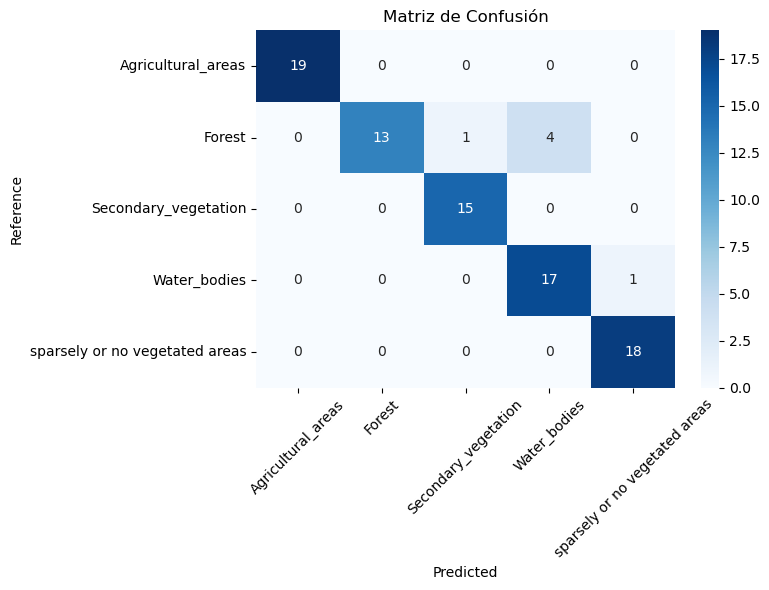

In [42]:
conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Reference")
plt.title("Matriz de Confusión")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [43]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Exactitud global: {accuracy * 100:.2f}%")


✅ Exactitud global: 93.18%


#### 6.1.2 Métricas añadiendo como covariable la clasificación no supervisada

In [54]:
# Leer la capa
points_gdf = gpd.read_file(vec_file, layer=vec_lyr)

rename_map = {
    1: "Agricultural_areas",
    2: "Forest",
    5: "Water_bodies",
    3: "Secondary_vegetation",
    4: "sparsely or no vegetated areas"
}

# Extraer valores del raster clasificado para cada punto
points_gdf["Classified"] = point_query(points_gdf, "clasificacion_rf_k_2018.kea", interpolate='nearest')

# Reemplazar los valores en la columna "Reference"
points_gdf["Classified"] = points_gdf["Classified"].replace(rename_map)
# Sobrescribir la misma capa en el mismo archivo
points_gdf.to_file(vec_file, layer=vec_lyr, driver="GPKG")

In [55]:
# Directorio para puntos de evaluación (por si se exportan)
out_pts_dir = "acc_pts"
os.makedirs(out_pts_dir, exist_ok=True)

# Directorio para resultados de métricas
out_stats_dir = "acc_stats"
os.makedirs(out_stats_dir, exist_ok=True)

print("Directorios creados o verificados correctamente.")

Directorios creados o verificados correctamente.


In [56]:
# Archivo de salida en GeoJSON
vec_refpts_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref.geojson")
vec_refpts_lyr = "cls_acc_assessment_pts_ref"

# Exportar la capa desde el GPKG a GeoJSON
rsgislib.vectorutils.vector_translate(
    vec_file=vec_file,
    vec_lyr="amazontesting", 
    out_vec_file=vec_refpts_file,
    out_vec_lyr=vec_refpts_lyr,
    out_format="GeoJSON",
    del_exist_vec=True
)

print("Puntos de evaluación exportados a GeoJSON correctamente.")

Deleting: acc_pts/cls_acc_assessment_pts_ref.geojson




  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                  | 1/100 [00:00<00:15,  6.36it/s]

Puntos de evaluación exportados a GeoJSON correctamente.


In [57]:
out_cls_img = "clasificacion_rf_k_2018.kea"
rsgislib.classification.pop_class_info_accuracy_pts(
    input_img=out_cls_img,
    vec_file=vec_refpts_file,
    vec_lyr=vec_refpts_lyr,
    rat_class_col="class_names",
    vec_class_col="Classified",
    vec_ref_col=None,
    vec_process_col=None,
)

/tmp/ipykernel_264/3186961064.py:2: RuntimeWarning: Field 'Classified' already exists. Renaming it as 'Classified2'
  rsgislib.classification.pop_class_info_accuracy_pts(


In [58]:
vec_refpts_vld_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref_vld.geojson")
vec_refpts_vld_lyr = "cls_acc_assessment_pts_ref_vld"
print(points_gdf )
points_gdf = points_gdf.drop(points_gdf[points_gdf["Classified"] == "NA"].index)
points_gdf.to_file(vec_refpts_vld_file, driver="GeoJSON")

                        Classified           Reference  \
0               Agricultural_areas  Agricultural_areas   
1               Agricultural_areas  Agricultural_areas   
2             Secondary_vegetation              Forest   
3                           Forest              Forest   
4                     Water_bodies        Water_bodies   
..                             ...                 ...   
83              Agricultural_areas  Agricultural_areas   
84  sparsely or no vegetated areas  Agricultural_areas   
85              Agricultural_areas  Agricultural_areas   
86  sparsely or no vegetated areas  Agricultural_areas   
87              Agricultural_areas  Agricultural_areas   

                         geometry  
0   POINT (978076.798 563122.154)  
1   POINT (957647.653 560918.123)  
2   POINT (959480.063 590390.022)  
3   POINT (964668.937 583237.615)  
4    POINT (951138.31 565984.646)  
..                            ...  
83  POINT (965356.311 567558.396)  
84  POINT (9643

In [59]:
from rsgislib.classification.classaccuracymetrics import calc_acc_metrics_vecsamples_img


out_json_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.json")
out_csv_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.csv")

calc_acc_metrics_vecsamples_img(
    vec_file=vec_refpts_vld_file,
    vec_lyr=vec_refpts_vld_lyr,
    ref_col="Reference",
    cls_col="Classified",
    cls_img=out_cls_img,
    img_cls_name_col="class_names",
    img_hist_col="Histogram",
    out_json_file=out_json_file,
    out_csv_file=out_csv_file,
)

{np.str_('Agricultural_areas'): {'precision': 0.7058823529411765,
  'recall': 0.631578947368421,
  'f1-score': 0.6666666666666666,
  'support': 19.0},
 np.str_('Forest'): {'precision': 0.8,
  'recall': 0.8888888888888888,
  'f1-score': 0.8421052631578947,
  'support': 18.0},
 np.str_('Secondary_vegetation'): {'precision': 0.8,
  'recall': 0.8,
  'f1-score': 0.8,
  'support': 15.0},
 np.str_('Water_bodies'): {'precision': 0.8181818181818182,
  'recall': 1.0,
  'f1-score': 0.9,
  'support': 18.0},
 np.str_('sparsely or no vegetated areas'): {'precision': 0.5714285714285714,
  'recall': 0.4444444444444444,
  'f1-score': 0.5,
  'support': 18.0},
 'accuracy': 0.75,
 'macro avg': {'precision': 0.7390985485103132,
  'recall': 0.7529824561403509,
  'f1-score': 0.7417543859649123,
  'support': 88.0},
 'weighted avg': {'precision': 0.7366449058962428,
  'recall': 0.75,
  'f1-score': 0.7389154704944179,
  'support': 88.0},
 'cohen_kappa': np.float64(0.687136393018746),
 'bal_accuracy_score': np.f

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo los puntos que sí fueron clasificados (evita NaN)
valid_points = points_gdf.dropna(subset=["Classified"])

# Asignar valores reales
y_true = valid_points["Reference"].astype(str)
y_pred = valid_points["Classified"].astype(str)

# 2. Obtener las clases únicas ordenadas (garantiza consistencia en el reporte)
unique_classes = sorted(set(y_true.unique()) | set(y_pred.unique()))

In [61]:
print("📊 Reporte de clasificación:")
print(classification_report(
    y_true, 
    y_pred, 
    labels=unique_classes,
    target_names=unique_classes,
    digits=3
))

📊 Reporte de clasificación:
                                precision    recall  f1-score   support

            Agricultural_areas      0.706     0.632     0.667        19
                        Forest      0.800     0.889     0.842        18
          Secondary_vegetation      0.800     0.800     0.800        15
                  Water_bodies      0.818     1.000     0.900        18
sparsely or no vegetated areas      0.571     0.444     0.500        18

                      accuracy                          0.750        88
                     macro avg      0.739     0.753     0.742        88
                  weighted avg      0.737     0.750     0.739        88



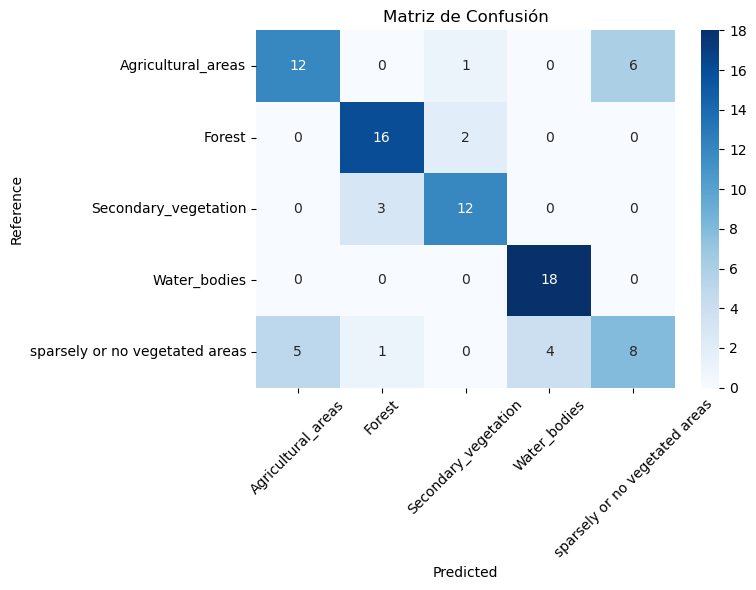

In [52]:
conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Reference")
plt.title("Matriz de Confusión")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [53]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Exactitud global: {accuracy * 100:.2f}%")


✅ Exactitud global: 75.00%


#### 6.2 Discusión de resultados

> **Reporte de clasificación clasificación tradicional supervisada**
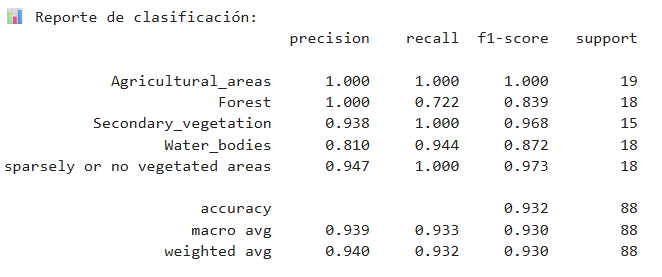

> **Reporte de clasificación clasificación supervisada + k-means**
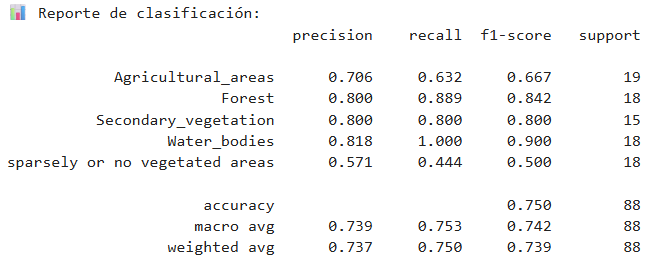

Tras incorporar la variable auxiliar procedente del k-means (k = 4) al modelo supervisado, la clase “Agricultural_areas” se ve penalizada de forma notable. Al forzar el espacio de características a cuatro conglomerados cuando el mapa final contiene cinco coberturas, los píxeles de la cobertura de áreas de agricultura tienden a mezclarse con la categoría “sparsely or no vegetated areas” que el k-means agrupa de forma conjunta. Cuando el random forest vuelve a entrenarse con esta covariable, hereda esa confusión y reduce tanto la *precision* como el *recall* para agricultura (0,706 y 0,632), elevando los falsos negativos u errores de omisión para dicha clase.

En contrapartida, los valores de *recall* mejoran para “Water_bodies” (1,000) y “Forest” (0,889). El k-means ayuda a atenuar el ruido introducido por las nubes, y visualmente se aprecia que los cuerpos de agua quedan mucho mejor delimitados, evitando la sobre-estimación que aparecía en la clasificación puramente supervisada.

Si comparamos el desempeño global, el primer modelo alcanzaba una exactitud del *93 %*, pero con una marcada sobre-representación de cuerpos de agua aunque cero errores en las clases de agricultura y áreas sin vegetación. Con la covariable de k-means la exactitud baja al *75 %*; sin embargo, el mapa resultante describe con mayor fidelidad los bosques y los cuerpos de agua, respondiendo mejor al objetivo de identificar estas coberturas específicas.

En suma, el ejercicio muestra que la “mejor” clasificación depende del propósito concreto: un mayor *overall accuracy* no siempre garantiza la calidad temática deseada. Elegir el método y los insumos adecuados requiere ponderar los compromisos entre precisión global y errores de omisión/comisión para las clases que realmente importan. 